In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
%reload_ext autoreload
%autoreload 2

from datetime import datetime

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

import lightgbm as lgb
from features import woe

basepath   = os.path.expanduser('../')

# train and validation fold
# TRAIN_PATH = os.path.join(basepath, 'data/processed/application_train_fold.feather')
# TEST_PATH  = os.path.join(basepath, 'data/processed/application_val_fold.feather')

# full training
TRAIN_PATH = os.path.join(basepath, 'data/processed/application_train.feather')
TEST_PATH  = os.path.join(basepath, 'data/processed/application_test.feather')

# MODEL PRESET
MODEL_PRESET   = 'M13'

# DATASET PREFIX
# DATASET_PREFIX = 'tr'
DATASET_PREFIX  = 'train'

## Load Processed Data

In [3]:
%%time

tr = pd.read_feather(f'{TRAIN_PATH}')
te = pd.read_feather(f'{TEST_PATH}')

# Application data from previous loans
bureau     = pd.read_feather(os.path.join(basepath, 'data/processed/bureau.feather'))
bureau_bal = pd.read_feather(os.path.join(basepath, 'data/processed/bureau_balance.feather'))
prev_app   = pd.read_pickle(os.path.join(basepath, 'data/processed/prev_app.pkl'))
pos_cash   = pd.read_pickle(os.path.join(basepath, 'data/processed/pos_cash.pkl'))

CPU times: user 377 ms, sys: 462 ms, total: 839 ms
Wall time: 2.36 s


In [4]:
# concat training and test set
data   = pd.concat((tr, te))
ntrain = len(tr) 

del tr, te
gc.collect();

## Feature Engineering

In [5]:
%%time

# deviation in three external scores
data.loc[:, 'EXT_SOURCE_DEV']  = data.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].apply(np.std, axis=1)

# sum of external scores
data.loc[:, 'EXT_SOURCE_SUM'] = data['EXT_SOURCE_1'].fillna(0) + data['EXT_SOURCE_2'].fillna(0) + data['EXT_SOURCE_3'].fillna(0)

# mean of external scores
data.loc[:, 'MEAN_EXTERNAL_SCORE'] = (data['EXT_SOURCE_1'].fillna(0) + data['EXT_SOURCE_2'].fillna(0) + data['EXT_SOURCE_3'].fillna(0)) / 3

# feature interactions
data.loc[:, 'EXT_3_1'] = data.loc[:, 'EXT_SOURCE_3'] / data.loc[:, 'EXT_SOURCE_1']
data.loc[:, 'EXT_3_2'] = data.loc[:, 'EXT_SOURCE_3'] / data.loc[:, 'EXT_SOURCE_2']
data.loc[:, 'EXT_2_1'] = data.loc[:, 'EXT_SOURCE_2'] / data.loc[:, 'EXT_SOURCE_1']

# relationship between amount credit and total income
data.loc[:, 'ratio_credit_income'] = data.loc[:, 'AMT_CREDIT'].map(np.log1p) / data.loc[:, 'AMT_INCOME_TOTAL'].map(np.log1p)

# relationship between annual amount to be paid and income
data.loc[:, 'ratio_annuity_income'] = data.loc[:, 'AMT_ANNUITY'] / data.loc[:, 'AMT_INCOME_TOTAL']

# relationship between amount annuity and age
data.loc[:, 'ratio_annuity_age'] = data.loc[:, 'AMT_ANNUITY'] / (-data.loc[:, 'DAYS_BIRTH'] / 365)

# number of missing values in an application
data.loc[:, 'num_missing_values'] = data.loc[:, data.columns.drop('TARGET')].isnull().sum(axis=1).values

# feature interaction between age and days employed
data.loc[:, 'age_plus_employed']  = data.loc[:, 'DAYS_BIRTH'] + data.loc[:, 'DAYS_EMPLOYED']
data.loc[:, 'ratio_age_employed'] = (data.DAYS_EMPLOYED) / (data.DAYS_BIRTH)

# ratio of value of goods against which loan is given to total income
data.loc[:, 'ratio_goods_income'] = data.loc[:, 'AMT_GOODS_PRICE'] / data.loc[:, 'AMT_INCOME_TOTAL']

# feature interaction between value of goods against which loan is given to annual loan amount to be paid
data.loc[:, 'ratio_goods_annuity'] = data.loc[:, 'AMT_GOODS_PRICE'] / data.loc[:, 'AMT_ANNUITY']
data.loc[:, 'mult_goods_annuity']  = data.loc[:, 'AMT_GOODS_PRICE'] * data.loc[:, 'AMT_ANNUITY']

# feature interaction value of goods and amount credit
data.loc[:, 'ratio_goods_credit'] = (data.loc[:, 'AMT_GOODS_PRICE'] / data.loc[:, 'AMT_CREDIT']).replace([np.inf, -np.inf], np.nan)
data.loc[:, 'mult_goods_credit']  = (data.loc[:, 'AMT_GOODS_PRICE'] * data.loc[:, 'AMT_CREDIT']).replace([np.inf, -np.inf], np.nan)

# feature interaction between annuity and amount credit
data.loc[:, 'ratio_annuity_credit'] = data.loc[:, 'AMT_ANNUITY'] / data.loc[:, 'AMT_CREDIT'].replace([np.inf, -np.inf], np.nan)

# feature interaction between amount credit and age
data.loc[:, 'ratio_credit_age'] = data.AMT_CREDIT / (-data.DAYS_BIRTH / 365)

# feature interaction between amount credit and days before application id was changed
data.loc[:, 'ratio_credit_id_change'] = (data.AMT_CREDIT / -data.DAYS_ID_PUBLISH).replace([np.inf, -np.inf], np.nan)

# feature interaction between days id publish and age
data.loc[:, 'ratio_id_change_age'] = (data.DAYS_ID_PUBLISH / (-data.DAYS_BIRTH / 365))

# ratio of annuity and external score
data.loc[:, 'ratio_annuity_score_1'] = (data.loc[:, 'AMT_ANNUITY'] / data.loc[:, 'EXT_SOURCE_1']).replace([np.inf, -np.inf], np.nan)
data.loc[:, 'ratio_annuity_score_2'] = (data.loc[:, 'AMT_ANNUITY'] / data.loc[:, 'EXT_SOURCE_2']).replace([np.inf, -np.inf], np.nan)
data.loc[:, 'ratio_annuity_score_3'] = (data.loc[:, 'AMT_ANNUITY'] / data.loc[:, 'EXT_SOURCE_3']).replace([np.inf, -np.inf], np.nan)

# ratio of annuity, credit multiplied by external scores
data.loc[:, 'ratio_credit_annuity_score_1'] = ((data.loc[:, 'AMT_ANNUITY'] / data.loc[:, 'AMT_CREDIT']) * data.loc[:, 'EXT_SOURCE_1']).replace([np.inf, -np.inf], np.nan)
data.loc[:, 'ratio_credit_annuity_score_2'] = ((data.loc[:, 'AMT_ANNUITY'] / data.loc[:, 'AMT_CREDIT']) * data.loc[:, 'EXT_SOURCE_2']).replace([np.inf, -np.inf], np.nan)
data.loc[:, 'ratio_credit_annuity_score_3'] = ((data.loc[:, 'AMT_ANNUITY'] / data.loc[:, 'AMT_CREDIT']) * data.loc[:, 'EXT_SOURCE_3']).replace([np.inf, -np.inf], np.nan)

##########################################################################################################
#                            BUREAU                                                                      #
##########################################################################################################

# previous loans
prev_loans = bureau

# number of previous loans for a particular user
prev_num_loans = prev_loans.groupby('SK_ID_CURR').size()

# number of previous active credits
num_active_credits = prev_loans.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].sum()

# mean days credit
mean_days_credit   = prev_loans.groupby('SK_ID_CURR')['DAYS_CREDIT'].mean()

# median days credit
median_days_credit = prev_loans.groupby('SK_ID_CURR')['DAYS_CREDIT'].median()

# std days credit
std_days_credit = prev_loans.groupby('SK_ID_CURR')['DAYS_CREDIT'].std()

# mean number of days overdue on any previous credit
mean_days_overdue = prev_loans.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean()

# mean number of days of CB credit at the time of application
mean_days_credit_end = prev_loans.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].mean()

# mean of maximum amount overdue on any credit line
mean_max_amt_overdue = prev_loans.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].mean()

# mean of total amount overdue on any credit line
mean_total_amt_overdue = prev_loans.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].mean()

# sum of num times credit was prolonged
sum_num_times_prolonged = prev_loans.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].sum()

# median of credit amount of different credit bureau loans
total_credit_amount = prev_loans.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()
mean_credit_amount  = prev_loans.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].mean()

# number of different types of credit taken from CREDIT BUREAU
num_diff_credits = prev_loans.groupby('SK_ID_CURR')['CREDIT_TYPE'].nunique()

# mean number of days of last credit update
mean_days_credit_update = prev_loans.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].mean()

# num times overdue credit date in the past
if os.path.exists(os.path.join(basepath, f'data/processed/{DATASET_PREFIX}_num_times_overdue.pkl')):
    num_times_overdue = pd.read_pickle(os.path.join(basepath, f'data/processed/{DATASET_PREFIX}_num_times_overdue.pkl'))
else:
    num_times_overdue  = prev_loans.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].apply(lambda x: np.sum(x > 0))
    num_times_overdue.to_pickle(os.path.join(basepath, f'data/processed/{DATASET_PREFIX}_num_times_overdue.pkl'))
    
data.loc[:, 'num_times_overdue'] = data.SK_ID_CURR.map(num_times_overdue).fillna(0).astype(np.int8)
    
    
# summary of amount of annuity of credit bureau loans
mean_cb_credit_annuity = prev_loans.groupby('SK_ID_CURR')['AMT_ANNUITY'].mean()
std_cb_credit_annuity  = prev_loans.groupby('SK_ID_CURR')['AMT_ANNUITY'].std()

# latest application reported to Home Credit
latest_credit = prev_loans.groupby('SK_ID_CURR')['DAYS_CREDIT'].max()
data.loc[:, 'latest_credit'] = data.SK_ID_CURR.map(latest_credit)

# day before current application date
credit_duration = (prev_loans.DAYS_CREDIT_ENDDATE - prev_loans.DAYS_CREDIT).map(np.abs).groupby(prev_loans.SK_ID_CURR).mean()
data.loc[:, 'credit_duration'] = data.SK_ID_CURR.map(credit_duration).replace([np.inf, -np.inf], np.nan)

# data.loc[:, 'ratio_total_credit_annuity'] = (data.loc[:, 'AMT_CREDIT'] + active_total_credit) / (data.loc[:, 'AMT_ANNUITY'])

# merge back with original dataframe
data.loc[:, 'num_prev_loans']           = data.SK_ID_CURR.map(prev_num_loans).fillna(0).values
data.loc[:, 'num_prev_active_credits']  = data.SK_ID_CURR.map(num_active_credits).fillna(0).values
data.loc[:, 'mean_days_credit']         = data.SK_ID_CURR.map(mean_days_credit).fillna(0).values
data.loc[:, 'median_days_credit']       = data.SK_ID_CURR.map(median_days_credit).fillna(0).values
data.loc[:, 'std_days_credit']          = data.SK_ID_CURR.map(std_days_credit).fillna(0).values
data.loc[:, 'mean_credit_days_overdue'] = data.SK_ID_CURR.map(mean_days_overdue).fillna(0).values
data.loc[:, 'mean_days_credit_end']     = data.SK_ID_CURR.map(mean_days_credit_end).fillna(0).values
data.loc[:, 'mean_max_amt_overdue']     = data.SK_ID_CURR.map(mean_max_amt_overdue).fillna(0).values
data.loc[:, 'mean_total_amt_overdue']   = data.SK_ID_CURR.map(mean_total_amt_overdue).values
data.loc[:, 'sum_num_times_prolonged']  = data.SK_ID_CURR.map(sum_num_times_prolonged).fillna(0).astype(np.int8).values
data.loc[:, 'total_credit_amount']      = data.SK_ID_CURR.map(total_credit_amount).fillna(0).values
data.loc[:, 'mean_credit_amount']       = data.SK_ID_CURR.map(mean_credit_amount).fillna(0).values
# data.loc[:, 'num_overdue_credits']      = data.SK_ID_CURR.map(num_overdue_credits).fillna(0).astype(np.int8)
data.loc[:, 'mean_cb_credit_annuity']   = data.SK_ID_CURR.map(mean_cb_credit_annuity).fillna(0).values
data.loc[:, 'std_cb_credit_annuity']    = data.SK_ID_CURR.map(std_cb_credit_annuity).fillna(0).values
data.loc[:, 'num_diff_credits']         = data.SK_ID_CURR.map(num_diff_credits).fillna(0).values
data.loc[:, 'mean_days_credit_update']  = data.SK_ID_CURR.map(mean_days_credit_update).fillna(0).values

# load ratio credit overdue to credit sum
# ratio_credit_overdue_sum = pd.read_pickle(os.path.join(basepath, 'data/processed/bureau_ratio_overdue_sum_credit.pkl'))
# data.loc[:, 'ratio_cedit_overdue_sum'] = data.SK_ID_CURR.map(ratio_credit_overdue_sum).fillna(-1)

# interaction between credit amount and duration of credit
credit_times_duration = (prev_loans.AMT_CREDIT_SUM.fillna(0) *\
                         (prev_loans.DAYS_CREDIT_ENDDATE - prev_loans.DAYS_CREDIT).map(np.abs))\
                        .replace([np.inf, -np.inf], np.nan)
credit_times_duration = credit_times_duration.groupby(prev_loans.SK_ID_CURR).mean()
data.loc[:, 'credit_times_duration'] = data.SK_ID_CURR.map(credit_times_duration)
    
#############################################################################################################
#                      FEATURE INTERACTIONS                                                                 #
#############################################################################################################

# feature interaction between credit bureau annuity, current annuity and total income
data.loc[:, 'ratio_cb_goods_annuity'] = (data.AMT_GOODS_PRICE / (data.mean_cb_credit_annuity + data.AMT_ANNUITY)).replace([np.inf, -np.inf], np.nan)

# feature interaction between mean days credit update and last time id was changed by user
data.loc[:, 'ratio_update_id']        = (data.mean_days_credit_update / data.DAYS_ID_PUBLISH).replace([np.inf, -np.inf], np.nan)

# feature interaction between mean credit amount of previous credits with current credit
data.loc[:, 'ratio_curr_prev_credit'] = data.AMT_CREDIT / data.mean_credit_amount

#############################################################################################################
#                           BUREAU and BUREAU BALANCE                                                       #
#############################################################################################################

prev_bal = bureau.loc[:, ['SK_ID_CURR', 'SK_ID_BUREAU']].merge(bureau_bal,
                                                   on='SK_ID_BUREAU',
                                                   how='left'
                                                  )

mean_status                      = prev_bal.groupby('SK_ID_BUREAU')['STATUS'].mean().fillna(-1)
prev_loans.loc[:, 'mean_status'] = prev_loans.SK_ID_BUREAU.map(mean_status).values

mean_status                = prev_loans.groupby('SK_ID_CURR')['mean_status'].mean()
data.loc[:, 'mean_status'] = data.SK_ID_CURR.map(mean_status).values

# previous loans history
credit_history                = prev_bal.groupby('SK_ID_CURR').size().fillna(0)
data.loc[:, 'credit_history'] = data.SK_ID_CURR.map(credit_history).values 

#############################################################################################################
#                          PREVIOUS APPLICATION                                                             #
#############################################################################################################

# number of previous applications
num_prev_apps                = prev_app.groupby('SK_ID_CURR').size()
data.loc[:, 'num_prev_apps'] = data.SK_ID_CURR.map(num_prev_apps).fillna(0).astype(np.int8) 

# mean amount to be paid annually for previous applications
prev_app_mean_annuity        = prev_app.groupby('SK_ID_CURR')['AMT_ANNUITY'].mean()
prev_app_mean_annuity        = data.SK_ID_CURR.map(prev_app_mean_annuity)

# ratio of previous annuity to current annuity
data.loc[:, 'ratio_prev_curr_annuity'] = (prev_app_mean_annuity / data.AMT_ANNUITY).replace([np.inf, -np.inf], np.nan)
data.loc[:, 'diff_prev_curr_annuity']  = (prev_app_mean_annuity - data.AMT_ANNUITY).replace([np.inf, -np.inf], np.nan)


# ratio of down payment amount to application amount sum
if os.path.exists(os.path.join(basepath, f'data/processed/{DATASET_PREFIX}_down_payment_to_application.pkl')):
    down_payment_to_application = pd.read_pickle(os.path.join(basepath, f'data/processed/{DATASET_PREFIX}_down_payment_to_application.pkl'))
else:    
    down_payment_to_application = prev_app.groupby('SK_ID_CURR').apply(lambda x: (x['AMT_DOWN_PAYMENT'].fillna(0) / x['AMT_APPLICATION']).sum())
    down_payment_to_application.to_pickle(os.path.join(basepath, f'data/processed/{DATASET_PREFIX}_down_payment_to_application.pkl'))

data.loc[:, 'down_payment_to_application'] = data.SK_ID_CURR.map(down_payment_to_application)

# mean interest rate on down payments of previous applications
mean_down_payment_rate                = prev_app.groupby('SK_ID_CURR')['RATE_DOWN_PAYMENT'].mean()
data.loc[:, 'mean_down_payment_rate'] = data.SK_ID_CURR.map(mean_down_payment_rate)

# most frequent rejection reason
if os.path.exists(os.path.join(basepath, f'data/processed/{DATASET_PREFIX}_most_freq_reject_reason.pkl')):
    most_freq_rejection_reason = pd.read_pickle(os.path.join(basepath, f'data/processed/{DATASET_PREFIX}_most_freq_reject_reason.pkl'))
else:
    most_freq_rejection_reason = prev_app.groupby('SK_ID_CURR').apply(lambda x: x.CODE_REJECT_REASON.value_counts().index.values[0])
    most_freq_rejection_reason.to_pickle(os.path.join(basepath, f'data/processed/{DATASET_PREFIX}_most_freq_reject_reason.pkl'))

data.loc[:, 'most_freq_rejection_reason'] = data.SK_ID_CURR.map(most_freq_rejection_reason)

# median amount annuity
median_annuity                = prev_app.groupby('SK_ID_CURR')['AMT_ANNUITY'].median()
data.loc[:, 'median_annuity'] = data.SK_ID_CURR.map(median_annuity)

###############################################################################################################
#                                 POS CASH                                                                    #
###############################################################################################################
mean_installments_future = pos_cash.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].mean()
data.loc[:, 'mean_installments_future'] = data.SK_ID_CURR.map(mean_installments_future)


# delete all intermediatory variables
del prev_num_loans, num_active_credits, prev_loans
del mean_days_credit, median_days_credit
del std_days_credit, mean_days_overdue, mean_days_credit_end
del mean_max_amt_overdue, sum_num_times_prolonged
del mean_cb_credit_annuity, std_cb_credit_annuity
del num_diff_credits, mean_days_credit_update
del mean_status, prev_bal, credit_history
del total_credit_amount, mean_credit_amount
del num_times_overdue, num_prev_apps
del prev_app, down_payment_to_application
del mean_down_payment_rate, most_freq_rejection_reason
del median_annuity, mean_installments_future
del latest_credit, credit_duration
del mean_total_amt_overdue

gc.collect();

CPU times: user 40.2 s, sys: 6.63 s, total: 46.9 s
Wall time: 47.6 s


In [6]:
# replace feature values with frequency less 20 with -100
for f in data.select_dtypes(include=['int8']).columns:
    if data[f].nunique() > 10:        
        low_freq_values = data[f].value_counts()
        low_freq_values = low_freq_values[low_freq_values < 20].index.values
        
        if len(low_freq_values) > 0:
            print('Feature: {}'.format(f))
            data.loc[data[f].isin(low_freq_values), f] = -100

Feature: CNT_CHILDREN
Feature: num_prev_apps


In [7]:
(data.isnull().sum() / len(data)).sort_values(ascending=False)

COMMONAREA_AVG                  0.697141
COMMONAREA_MODE                 0.697141
COMMONAREA_MEDI                 0.697141
NONLIVINGAPARTMENTS_MEDI        0.692933
NONLIVINGAPARTMENTS_MODE        0.692933
NONLIVINGAPARTMENTS_AVG         0.692933
LIVINGAPARTMENTS_AVG            0.682037
LIVINGAPARTMENTS_MEDI           0.682037
LIVINGAPARTMENTS_MODE           0.682037
FLOORSMIN_AVG                   0.676785
FLOORSMIN_MODE                  0.676785
FLOORSMIN_MEDI                  0.676785
YEARS_BUILD_AVG                 0.663306
YEARS_BUILD_MEDI                0.663306
YEARS_BUILD_MODE                0.663306
OWN_CAR_AGE                     0.660316
EXT_3_1                         0.625757
LANDAREA_MODE                   0.591835
LANDAREA_AVG                    0.591835
LANDAREA_MEDI                   0.591835
BASEMENTAREA_MEDI               0.582684
BASEMENTAREA_MODE               0.582684
BASEMENTAREA_AVG                0.582684
NONLIVINGAREA_AVG               0.549511
NONLIVINGAREA_ME

In [8]:
# unpack to train and test
tr = data.iloc[:ntrain]
te = data.iloc[ntrain:]

del data
gc.collect();

## Modelling

In [9]:
COLS_TO_REMOVE = [
                  'FLAG_DOCUMENT_21',
                  'FLAG_DOCUMENT_4',
                  'FLAG_MOBIL',
                  'FLAG_DOCUMENT_2',
                  'FLAG_DOCUMENT_20',
                  'FLAG_DOCUMENT_9',
                  'FLAG_DOCUMENT_17',
                  'FLAG_DOCUMENT_19',
                  'FLAG_DOCUMENT_5',
                  'FLAG_CONT_MOBILE',
                  'FLAG_DOCUMENT_10',
                  'HOUSETYPE_MODE',
                  'FLAG_DOCUMENT_12',
                  'FLAG_DOCUMENT_7',
                  'FLAG_DOCUMENT_11',
                  'AMT_REQ_CREDIT_BUREAU_HOUR',
                  'LIVE_REGION_NOT_WORK_REGION',
                  'AMT_REQ_CREDIT_BUREAU_DAY',
                  'FLAG_DOCUMENT_15',
                  'EMERGENCYSTATE_MODE',
                  'SK_ID_CURR',
                  'FLAG_EMP_PHONE',
                  'TARGET'
                ]

In [10]:
features = [f for f in tr.columns if f not in COLS_TO_REMOVE]

Xtr  = tr.loc[:, features]
ytr  = tr.loc[:, 'TARGET']

Xval = te.loc[:, features]
# yval = te.loc[:, 'TARGET'] # only execute during validation phase

del tr, te
gc.collect();

In [11]:
print('Number of features used in the model are: {}'.format(len(features)))

Number of features used in the model are: 159


### Validation

In [12]:
params = {
    'objective': 'binary',
    'learning_rate': .02,
    'metric': 'auc',
    'min_data_in_leaf': 100,
    'num_leaves': 31,
    'feature_fraction': .7,
    'bagging_fraction': .8,
    'min_child_weight': 1.,
    'nthread': 4
}

ltrain = lgb.Dataset(Xtr, ytr, feature_name=features)
lval   = lgb.Dataset(Xval, yval, feature_name=features)

valid_sets  = [ltrain, lval]
valid_names = ['train', 'val']

num_boost_round       = 5000
early_stopping_rounds = 100

m = lgb.train(params, 
              ltrain, 
              num_boost_round, 
              valid_sets=valid_sets, 
              valid_names=valid_names, 
              early_stopping_rounds=early_stopping_rounds, 
              verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.735351	val's auc: 0.728677
[40]	train's auc: 0.738656	val's auc: 0.731095
[60]	train's auc: 0.7419	val's auc: 0.73345
[80]	train's auc: 0.745535	val's auc: 0.736148
[100]	train's auc: 0.749384	val's auc: 0.739803
[120]	train's auc: 0.752933	val's auc: 0.742915
[140]	train's auc: 0.757004	val's auc: 0.746011
[160]	train's auc: 0.761783	val's auc: 0.749939
[180]	train's auc: 0.766235	val's auc: 0.75337
[200]	train's auc: 0.770493	val's auc: 0.756395
[220]	train's auc: 0.775129	val's auc: 0.759909
[240]	train's auc: 0.779088	val's auc: 0.762419
[260]	train's auc: 0.782588	val's auc: 0.764308
[280]	train's auc: 0.785828	val's auc: 0.766172
[300]	train's auc: 0.788776	val's auc: 0.767536
[320]	train's auc: 0.791722	val's auc: 0.768766
[340]	train's auc: 0.794501	val's auc: 0.769923
[360]	train's auc: 0.797214	val's auc: 0.770849
[380]	train's auc: 0.799771	val's auc: 0.77173
[400]	train's auc: 0.802191	val's 

`[1438]	train's auc: 0.884329	val's auc: 0.778225`

### Feature Importance

In [13]:
# feature importance df
feat_imp = pd.DataFrame({'features': features,
                         'imp': m.feature_importance()
                        })

feat_imp.sort_values(by='imp', ascending=False)

,features,imp
116,ratio_annuity_credit,1215
157,mean_installments_future,984
100,EXT_SOURCE_SUM,842
34,EXT_SOURCE_2,788
35,EXT_SOURCE_3,730
20,DAYS_BIRTH,727
114,ratio_goods_credit,625
127,latest_credit,613
151,ratio_prev_curr_annuity,541
153,down_payment_to_application,536


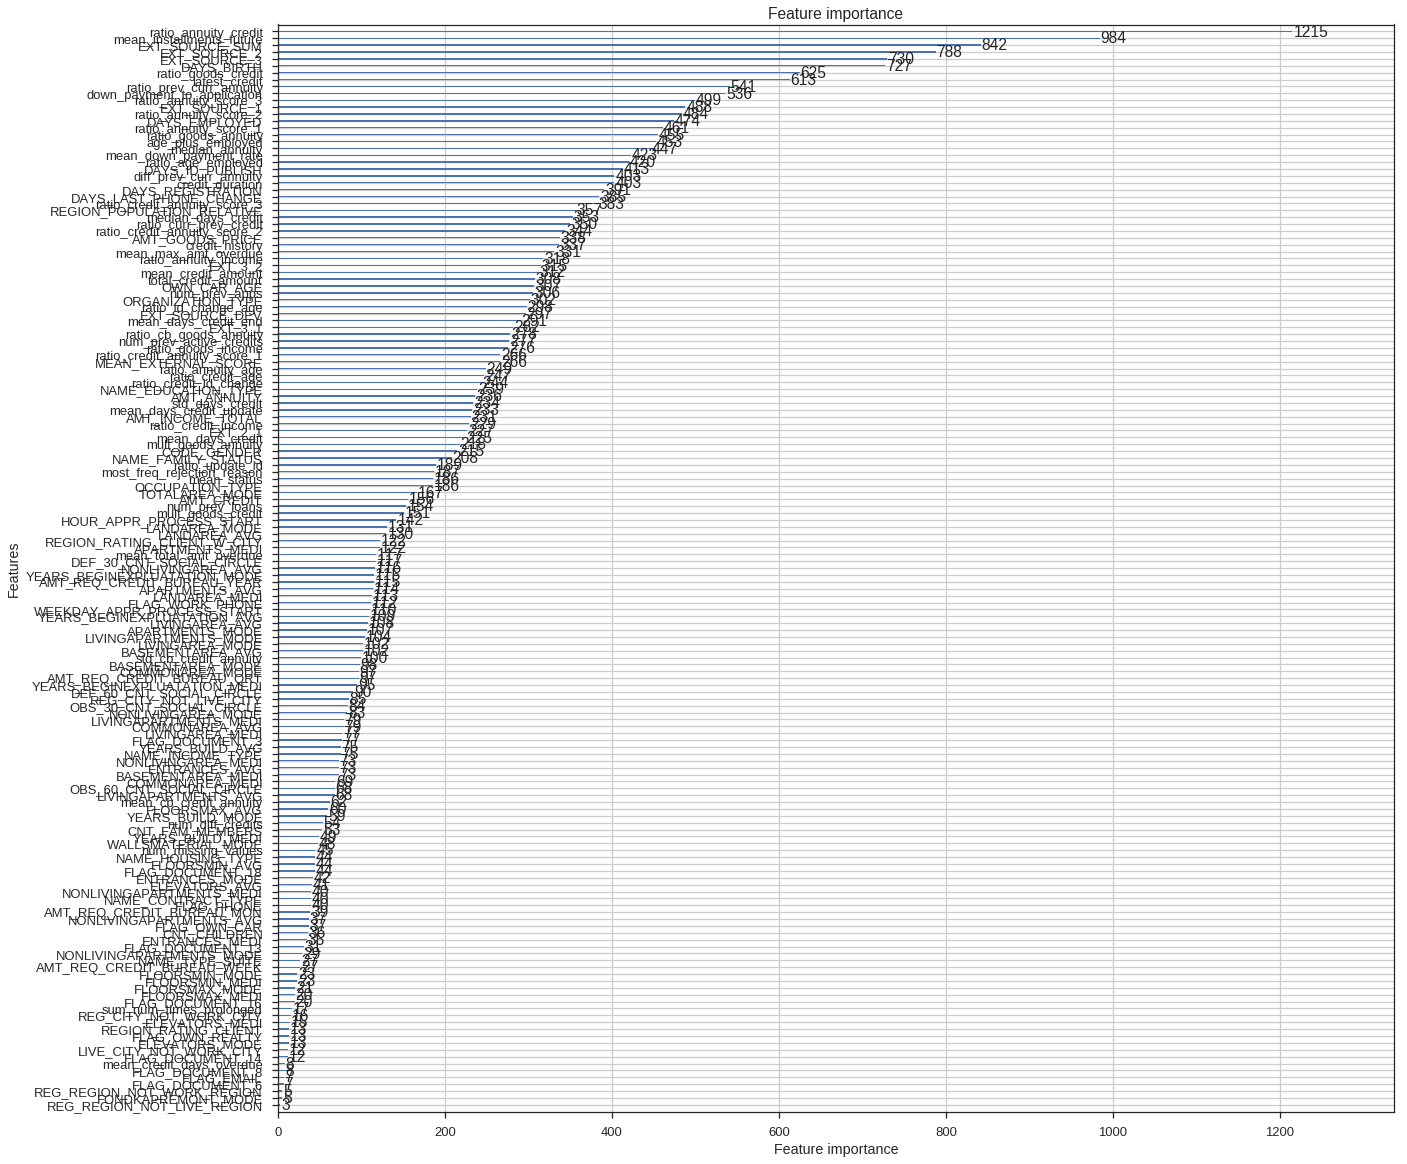

In [14]:
fig, ax = plt.subplots(1, figsize=(20, 20))
lgb.plot_importance(m, ax=ax);

### OOF Predictions

In [13]:
%%time

HOLDOUT_SCORE  = 0.778225

oof_preds = m.predict(Xval)
joblib.dump(oof_preds, os.path.join(basepath, f'data/oof_sub/{MODEL_PRESET}_{HOLDOUT_SCORE}_preds.pkl'))

CPU times: user 13.9 s, sys: 64.7 ms, total: 13.9 s
Wall time: 4.9 s


### Full Training

In [12]:
%%time

params = {
    'objective': 'binary',
    'learning_rate': (.02 / 1.2),
    'metric': 'auc',
    'min_data_in_leaf': 100,
    'num_leaves': 31,
    'feature_fraction': .7,
    'bagging_fraction': .8,
    'min_child_weight': 1.,
    'nthread': 4
}

BEST_ITERATION  = 1438

num_boost_round = int(BEST_ITERATION * 1.2)
ltrain          = lgb.Dataset(Xtr, ytr, feature_name=features)

m           = lgb.train(params, ltrain, num_boost_round)
final_preds = m.predict(Xval)

CPU times: user 26min 7s, sys: 9.92 s, total: 26min 17s
Wall time: 10min 24s


In [13]:
HOLDOUT_SCORE  = 0.778225

sub_identifier = "%s-%s-%.5f" % (datetime.now().strftime('%Y%m%d-%H%M'), MODEL_PRESET, HOLDOUT_SCORE)

sub           = pd.read_csv('../data/raw/sample_submission.csv.zip')
sub['TARGET'] = final_preds

sub.to_csv(os.path.join(basepath, 'submissions/%s.csv'%(sub_identifier)), index=False)